In [75]:
# Imports
import vaex
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.optimizers import RMSprop
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

### Data Preperation

In [76]:
timeB = 4
resolution = 7
hdf = vaex.open("data/trips/trips_grouped_" + str(timeB) + "h_r" + str(resolution) + ".hdf5")
df = hdf.to_pandas_df()

In [77]:
df.columns

Index(['start_day', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'ts_start_4_hour', 'start_4_hour',
       'start_4_hour_sin', 'start_4_hour_cos', 'pickup_hex_7', 'demand',
       'Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Company_encoded', 'Taxi ID_encoded',
       'Payment Type_Dispute', 'Payment Type_Unknown', 'Payment Type_Prcard',
       'Payment Type_Cash', 'Payment Type_Credit Card', 'Payment Type_Pcard',
       'Payment Type_No Charge'],
      dtype='object')

In [78]:
# Independent variables columns
iVars = ["start_month", "start_weekday", "start_4_hour", "pickup_hex_7"]

# All interesting columns
iColumns = ["demand"] + iVars

# Select interesting columns
sdf = df[iColumns]

In [79]:
# Removing Rides without a Hexagon/ Start-Location
sdf = sdf[(sdf["pickup_hex_7"].notna()) & (sdf["pickup_hex_7"] != "None")]

In [80]:
sdf 

,demand,start_month,start_weekday,start_4_hour,pickup_hex_7
0,1604,6,6,8,872c21191ffffff
1,40,4,1,4,872c21014ffffff
2,5774,4,4,8,872c2119cffffff
3,10268,4,4,20,872c2119cffffff
4,766,4,5,16,872c21016ffffff
...,...,...,...,...,...
54085,2,4,2,20,872c21cdeffffff
54086,3,3,5,0,872c21ccbffffff
54087,1,2,5,0,872c21cd2ffffff
54088,4,4,3,12,872c21ccaffffff


In [81]:
# Devide into X andf y
data = sdf
X = data[iVars]
y = data["demand"]

# Convert Hexagon into Dummies
X = pd.get_dummies(X, columns = ["pickup_hex_7"])

# Convert into float for Keras
X = X.astype("float32")
y = y.astype("float")

In [82]:
# Print shape to know, that it fits for model
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (49710, 33)
y shape: (49710,)


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True)

In [84]:
print("X_train: "+ str(len(X_train)))
print("X_test: "+ str(len(X_test)))
print("X_val: "+ str(len(X_val)))
print("y_train: "+ str(len(y_train)))
print("y_test: "+ str(len(y_test)))
print("y_val: "+ str(len(y_val)))

X_train: 31814
X_test: 9942
X_val: 7954
y_train: 31814
y_test: 9942
y_val: 7954


## Jetzt wirklich NN

In [85]:
def plot_true_vs_prediction(y_pred,y_test):
    
    y_pred = y_pred.flatten()
    # create sorted series for true and predicted values
    y_pred_series = pd.Series(np.array(y_pred) ,index = y_test.index) 
    y_pred_series_sorted = y_pred_series.sort_index()
    y_test_sorted = y_test.sort_index()

    # plot true vs predicted values
    fig,ax = plt.subplots(figsize = (20, 10), dpi = 80) 
    ax.plot(y_test_sorted, label = "true", linewidth = 2, color = "tab:gray")
    ax.plot(y_pred_series_sorted, label = "prediction", linewidth = 1, alpha = 0.6, color = "tab:blue")
    ax.set_ylabel('Total System-Level Demand')
    ax.set_xlabel('Date')
    ax.legend()
    plt.show()
    
    # evaluation metrics
    print("Mean Squared Error:",mean_squared_error(y_test,y_pred))
    print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))

In [86]:
def plot_history(history):

    train_loss = history.history['loss']
    train_mae = history.history['mae']
    val_loss = history.history['val_loss']
    val_mae = history.history['val_mae']
    
    # Create an array of epochs
    epochs = range(1, len(train_loss) + 1)

    # Plot training loss vs. validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
    # Plot log10 of training loss vs. validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, np.log10(train_loss), 'b-', label='Training Loss')
    plt.plot(epochs, np.log10(val_loss), 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Log10 Loss')
    plt.legend()
    plt.show()
    
    # Plot training mean squared error vs. validation mae
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_mae, 'b-', label='Training MAE')
    plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    # Plot log training mean squared error vs. log validation mae
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, np.log10(train_mae), 'b-', label='Log10 Training MAE')
    plt.plot(epochs, np.log10(val_mae), 'r-', label='Log10 Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()


In [87]:
# Determine the number of input layers based on X_encoded shape
num_input_layers = X.shape[1]
num_input_layers

33

In [88]:
# Define the neural network architecture
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(num_input_layers,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
#model.compile(loss='mean_squared_error', optimizer='adam')
opt = RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mae'])
#model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [89]:
# Train the model
#history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)
#model.fit(X_train, y_train, epochs=30, batch_size=32)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

Epoch 1/30


995/995 [==============================] - 6s 4ms/step - loss: 2544240.0000 - mae: 754.1906 - val_loss: 2208913.5000 - val_mae: 801.6833
Epoch 2/30
995/995 [==============================] - 4s 4ms/step - loss: 2206925.2500 - mae: 780.3258 - val_loss: 1832476.8750 - val_mae: 698.3719
Epoch 3/30
995/995 [==============================] - 4s 4ms/step - loss: 1406908.6250 - mae: 538.8921 - val_loss: 881321.6875 - val_mae: 420.2399
Epoch 4/30
995/995 [==============================] - 4s 4ms/step - loss: 744879.1250 - mae: 371.4341 - val_loss: 586754.8125 - val_mae: 333.1525
Epoch 5/30
995/995 [==============================] - 4s 4ms/step - loss: 589163.7500 - mae: 326.2713 - val_loss: 521373.0625 - val_mae: 310.2310
Epoch 6/30
995/995 [==============================] - 4s 4ms/step - loss: 542860.0000 - mae: 312.5975 - val_loss: 488908.6562 - val_mae: 301.1055
Epoch 7/30
995/995 [==============================] - 4s 4ms/step - loss: 516725.7188 - mae: 306.0391 - val_loss: 472852.3125 - va

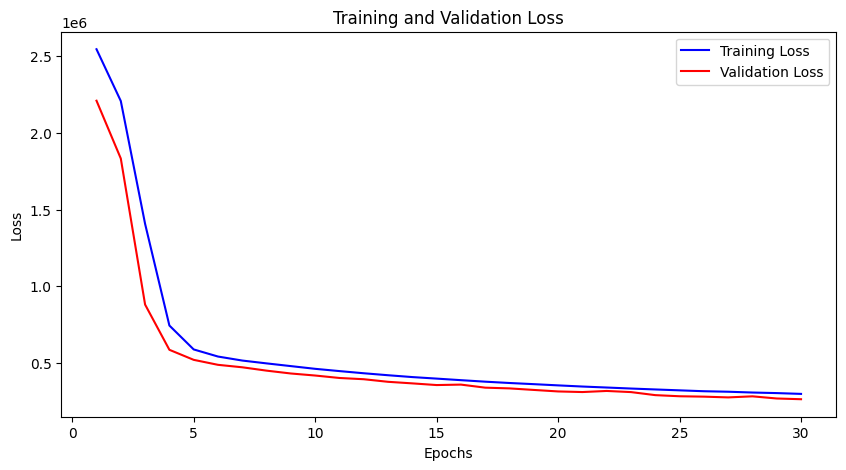

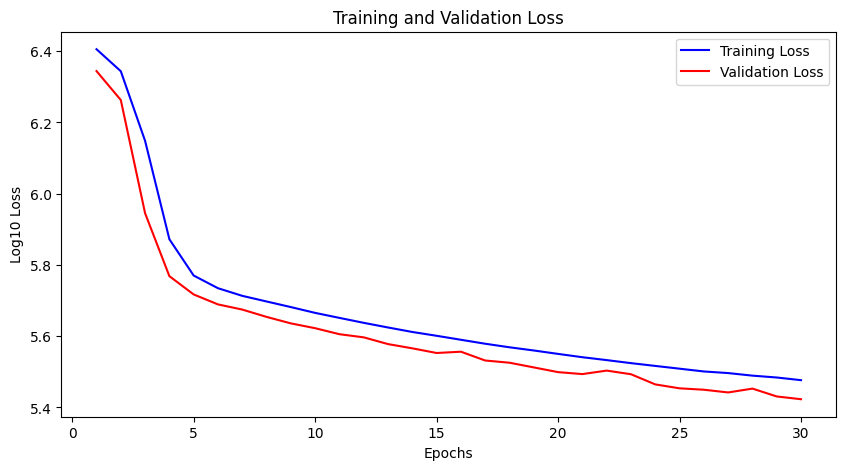

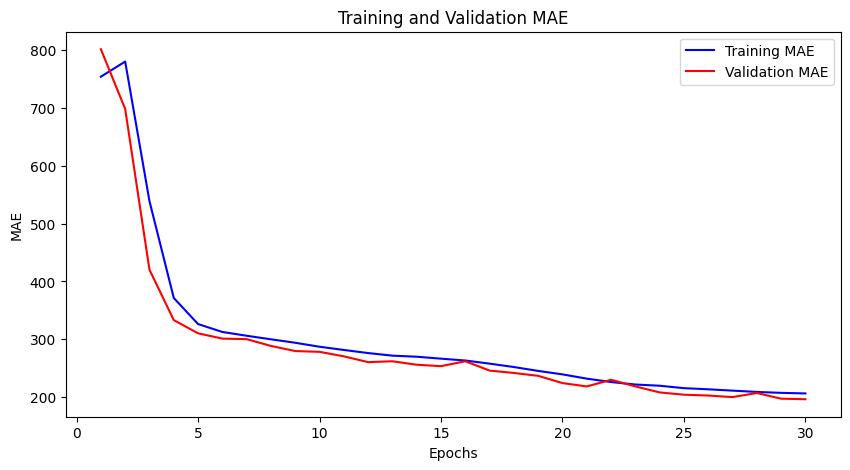

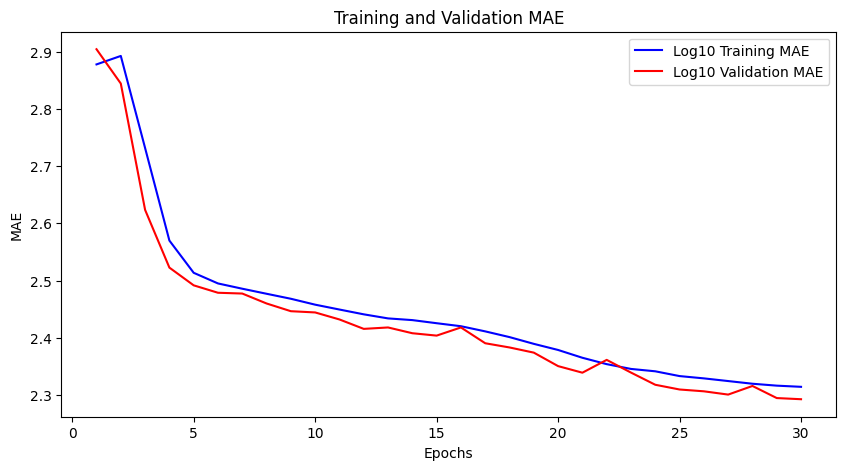

In [90]:
plot_history(history)

In [91]:
# Step 6: Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Mean Absolute Error:", test_mae)


311/311 [==============================] - 1s 3ms/step - loss: 298095.0312 - mae: 204.4931
Test Loss: 298095.03125
Test Mean Absolute Error: 204.49314880371094


311/311 [==============================] - 1s 2ms/step


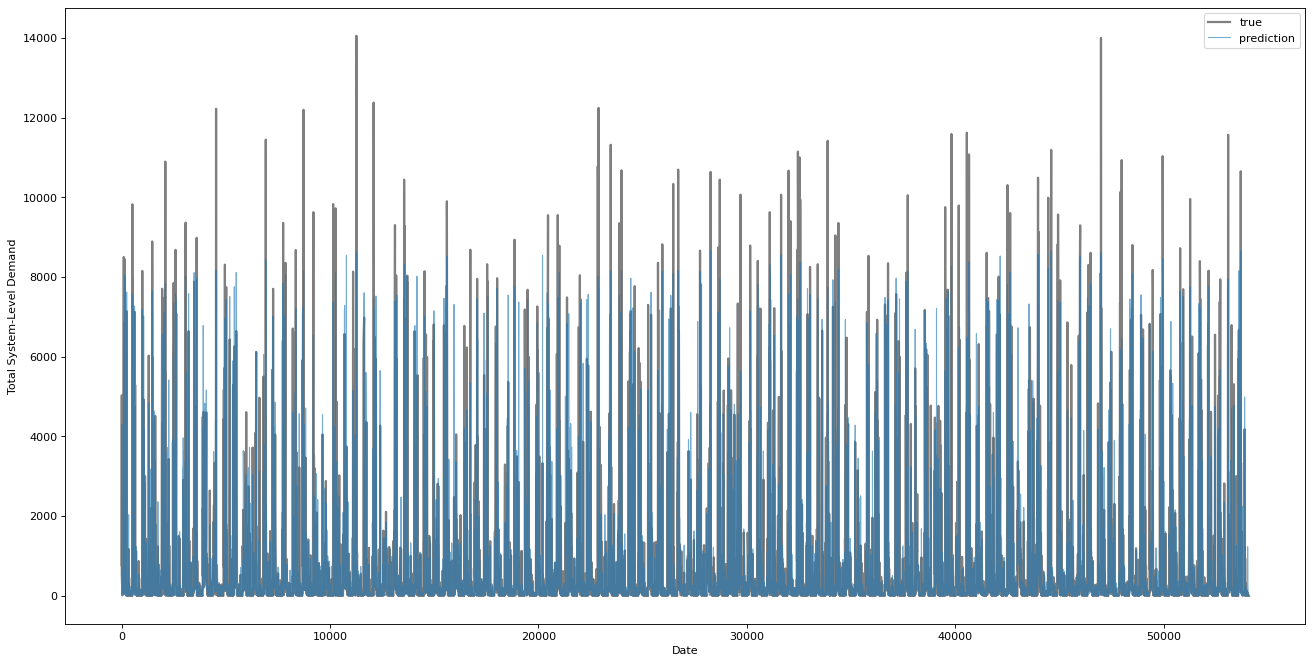

Mean Squared Error: 298095.0935522763
Mean Absolute Error: 204.49306252580178


In [92]:
plot_true_vs_prediction(model.predict(X_test),y_test)

In [93]:
example = X_test
example["demand"] = y_test

In [94]:
X_test

,start_month,start_weekday,start_4_hour,pickup_hex_7_872c21002ffffff,pickup_hex_7_872c21003ffffff,pickup_hex_7_872c21010ffffff,pickup_hex_7_872c21011ffffff,pickup_hex_7_872c21014ffffff,pickup_hex_7_872c21015ffffff,pickup_hex_7_872c21016ffffff,...,pickup_hex_7_872c21c99ffffff,pickup_hex_7_872c21c9bffffff,pickup_hex_7_872c21ccaffffff,pickup_hex_7_872c21ccbffffff,pickup_hex_7_872c21cd2ffffff,pickup_hex_7_872c21cd3ffffff,pickup_hex_7_872c21cd8ffffff,pickup_hex_7_872c21cd9ffffff,pickup_hex_7_872c21cdeffffff,demand
51236,6.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,368.0
38089,12.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1156.0
22430,2.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202.0
44164,5.0,3.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
29897,9.0,4.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16718,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,333.0
46353,4.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0
53114,12.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
8541,8.0,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,268.0


In [95]:
example

,start_month,start_weekday,start_4_hour,pickup_hex_7_872c21002ffffff,pickup_hex_7_872c21003ffffff,pickup_hex_7_872c21010ffffff,pickup_hex_7_872c21011ffffff,pickup_hex_7_872c21014ffffff,pickup_hex_7_872c21015ffffff,pickup_hex_7_872c21016ffffff,...,pickup_hex_7_872c21c99ffffff,pickup_hex_7_872c21c9bffffff,pickup_hex_7_872c21ccaffffff,pickup_hex_7_872c21ccbffffff,pickup_hex_7_872c21cd2ffffff,pickup_hex_7_872c21cd3ffffff,pickup_hex_7_872c21cd8ffffff,pickup_hex_7_872c21cd9ffffff,pickup_hex_7_872c21cdeffffff,demand
51236,6.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,368.0
38089,12.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1156.0
22430,2.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202.0
44164,5.0,3.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
29897,9.0,4.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16718,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,333.0
46353,4.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0
53114,12.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
8541,8.0,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,268.0


In [96]:
example["predicted_demand"] = model.predict(X_test)

type: in user code:

    File "c:\Users\NickPC\.virtualenvs\AAA_2023-67gSWIjI\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\NickPC\.virtualenvs\AAA_2023-67gSWIjI\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\NickPC\.virtualenvs\AAA_2023-67gSWIjI\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\NickPC\.virtualenvs\AAA_2023-67gSWIjI\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\NickPC\.virtualenvs\AAA_2023-67gSWIjI\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\NickPC\.virtualenvs\AAA_2023-67gSWIjI\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 33), found shape=(None, 34)


In [ ]:
example

,demand,start_month,start_weekday,start_4_hour,pickup_hex_7,predicted_demand
0,1604,6,6,8,872c21191ffffff,1604.711548
1,40,4,1,4,872c21014ffffff,40.050819
2,5774,4,4,8,872c2119cffffff,5776.816895
3,10268,4,4,20,872c2119cffffff,10272.869141
4,766,4,5,16,872c21016ffffff,766.301941
...,...,...,...,...,...,...
54085,2,4,2,20,872c21cdeffffff,2.083194
54086,3,3,5,0,872c21ccbffffff,3.060390
54087,1,2,5,0,872c21cd2ffffff,1.104648
54088,4,4,3,12,872c21ccaffffff,3.897506


In [ ]:
# Use model.predict() to obtain predictions
predictions = model.predict(demand_values_reshaped)


# Assign the predictions to the 'predicted_demand' column
df_with_predictions['predicted_demand'] = predictions

# Display the DataFrame with the added 'predicted_demand' column
print(df_with_predictions)

type: in user code:

    File "c:\Users\NickPC\.virtualenvs\AAA_2023-67gSWIjI\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\NickPC\.virtualenvs\AAA_2023-67gSWIjI\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\NickPC\.virtualenvs\AAA_2023-67gSWIjI\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\NickPC\.virtualenvs\AAA_2023-67gSWIjI\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\NickPC\.virtualenvs\AAA_2023-67gSWIjI\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\NickPC\.virtualenvs\AAA_2023-67gSWIjI\lib\site-packages\keras\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=int64)
      • training=False
      • mask=None
